# 순환신경망 RNN
```
단어 임베딩:테스트를 숫자로 표현
벡터(숫자배열)를 입력으로 사용
!. 원핫인코딩(one-hot-encording)
1000 0100 0010 0001
2. 고유번호로 각 단어를 인코딩 정수인코딩
cat : 1, mat : 2 [1,2] 밀집 벡터
3.단어 임베딩
유사한 단어가 유사한 인코딩을 갖는 방법, 부동소수점
```

In [ ]:
import tensorflow as tf
import os
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

In [ ]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1_extracted/aclImdb')
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'README', 'imdbEr.txt', 'test']

In [ ]:
dataset_dir + '/train', os.path.dirname(dataset_dir)

('./aclImdb_v1_extracted/aclImdb/train', './aclImdb_v1_extracted')

In [ ]:
paths = os.path.join(dataset,'aclImdb')
train_dir = os.path.join(paths,'train')
test_dir =  os.path.join(paths,'test')
# train_dir 파일 및 디렉터리 명
os.listdir(train_dir)

['labeledBow.feat',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'unsup',
 'pos',
 'urls_unsup.txt',
 'urls_neg.txt']

In [ ]:
import shutil
shutil.rmtree(train_dir+'/unsup')

In [ ]:
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size = 1024,
    validation_split=0.2,
    subset = 'training',
    seed=123
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size = 1024,
    validation_split=0.2,
    subset = 'validation',
    seed=123
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
text_bech, label_bech = next(iter(train_ds))
text_bech[0], label_bech[0]

(<tf.Tensor: shape=(), dtype=string, numpy=b'It\'s always nice to see Angela Bassett getting to do a role that she can really sink her teeth into. She is at times intense, funny and even sexy in her role as Lena, a "colored" woman forced to make a home on a desolate mudbank just outside of Cape Town, South Africa. Danny Glover is also good in a not entirely sympathetic role as her partner, Boesman. Willie Jonah gives a finely nuanced performance as the stranger that discovers Boesman and Lena\'s new living area. It\'s not often that you get a chance to see an intelligent film dealing with mature themes. Although it is based on a play, the late director John Berry (who also directed Claudine) opens the material up by having the film shot in the widescreen Cinemascope format. He also keeps things visually interesting through the creative blocking of actors and by showing us things only mentioned in the play. Just like Diahann Carroll in Claudine, John Berry may have directed Angela Basse

In [ ]:
# 성능튜닝  AUTOTUNE 을 사용 - 라이브러리
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 단어 임베딩  정수 인덱스에서 밀집벡터 매핑
# dim 차원 차수
# 1000개의 고유한 단어를 포함하는 단어 사전 0~999
#5 = 출력벡터의 차원수 각 단어를 5개의 벡터로 변환함
# [2,45,600] -> [[0.1, -0.2...].. [], [] ]
embbeding_layer = tf.keras.layers.Embedding(input_dim=1000, output_dim=5)
# 샘플 입력(배치 크기:2, 문장길이 :3)
sample_input = tf.constant([[0,1,2,],[3,4,5]])
embedding_output = embbeding_layer(sample_input)
print(embedding_output.shape)
embedding_output

(2, 3, 5)


<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[ 4.8946626e-03,  1.3927791e-02, -3.9578341e-02,  4.7253739e-02,
         -5.6635588e-05],
        [ 2.4415318e-02,  2.8052080e-02, -3.2008611e-02, -4.0286295e-03,
         -2.3877000e-02],
        [-4.2448260e-02,  2.7016629e-02,  2.1467153e-02, -1.1411406e-02,
         -7.4354298e-03]],

       [[ 4.8778541e-03,  6.8263784e-03, -3.9510250e-02, -3.9952349e-02,
         -3.5593510e-02],
        [ 5.7595260e-03,  3.7325207e-02,  4.4700120e-02,  8.9234821e-03,
         -2.1837130e-03],
        [ 1.8200029e-02, -4.9946059e-02,  1.5262850e-03, -5.0971135e-03,
          3.3352565e-02]]], dtype=float32)>

# 문장을 전처리
```
소문자로 통일
특수기호 제거 string.punctuation
```

In [ ]:
import string
string.punctuation
# <br />

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def custom_standardztion(input_data):
  lowercase = tf.strings.lower(input_data)
  stringed_html = tf.strings.regex_replace(lowercase, '<.*?>', ' ')
  return tf.strings.regex_replace(stringed_html, '[^a-z0-9\s]', ' ')

In [ ]:
from typing import Text
# 어휘 크기와 문장의 길이를 설정
vocab_size = 10000  # 최대 어휘크기(10000)
sequence_length = 100 # 문장의 최대 길이(100 단어로 맞춤)
# 짧은 문장은 패딩(0) 추가
# 긴 문장은 잘라(truncation) 고정된길이를유지
vectorize_layer =   tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,  # 어휘사전 크기 제한
    standardize=custom_standardztion,
    output_mode = 'int',  # 단어를 정수인덱스
    output_sequence_length=sequence_length # 패딩과 자르기적용
)
text_ds = train_ds.map(lambda x,y : tf.strings.as_string(x))
vectorize_layer.adapt(text_ds)

In [ ]:
# 모델 만들기
embedding_dim = 16
model = tf.keras.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"),  # 단어를 고차원 임베딩 공간에 매핑
  #tf.keras.layers.GlobalAveragePooling1D(),  # 시퀀스데이터의 평균적인 정보를 추출
  tf.keras.layers.SimpleRNN(64),
  # 분류기
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  #binary_crossentropy
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.4957 - loss: 0.6965 - val_accuracy: 0.4886 - val_loss: 0.6932
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.4957 - loss: 0.6889 - val_accuracy: 0.4886 - val_loss: 0.6971
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.4976 - loss: 0.6721 - val_accuracy: 0.5380 - val_loss: 0.6800
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.6039 - loss: 0.6179 - val_accuracy: 0.7052 - val_loss: 0.5974
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - accuracy: 0.7672 - loss: 0.4871 - val_accuracy: 0.7616 - val_loss: 0.5249
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.8490 - loss: 0.3569 - val_accuracy: 0.7632 - val_loss: 0.4894
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - accuracy: 0.8965 - loss: 0.2580 - val_accuracy: 0.7920 - val_loss: 0.5500
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.9370 - loss: 0.1807 - val_accuracy: 0

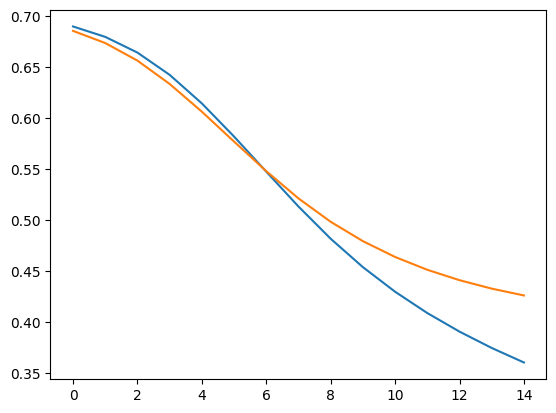

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
from subprocess import call
# RNN 모델 만들기
embedding_dim = 16
model = tf.keras.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"),  # 단어를 고차원 임베딩 공간에 매핑
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.SimpleRNN(64) ,
  tf.keras.layers.Dropout(0.5),
  # 분류기
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  #binary_crossentropy
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100 ,
    callbacks=callbacks
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.4973 - loss: 0.7058 - val_accuracy: 0.4886 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.4977 - loss: 0.6946 - val_accuracy: 0.4886 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.4963 - loss: 0.6920 - val_accuracy: 0.4886 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.5167 - loss: 0.6813 - val_accuracy: 0.6650 - val_loss: 0.6167 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.6342 - loss: 0.6126 - val_accuracy: 0.7552 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.7626 - loss: 0.5042 - val_accuracy: 0.7586 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.8107 - loss: 

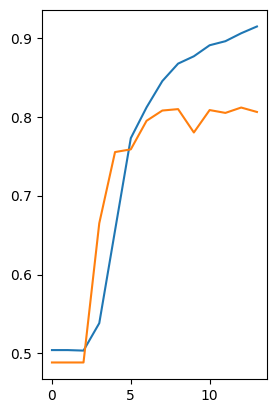

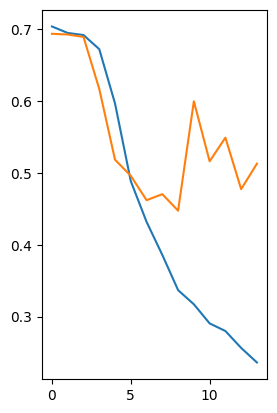

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

```
단어임베딩
  전통적으로 단어는 원핫표현
  cat [1,0,0] dog [0,1,0]
  단점 : 단어간의 유사성을 반영하지 못함 cat dog는 의미상 유사하지만
  벡터간의 거리는 동일하거나 등..
  차원문제 : 어휘가 크면 벡터차원이증가(희소행렬문제)
  해결 : 단어임베딩은 단어를 저차원(30~500차원) 실수 벡터로 표현해서 의미적으로 유사한 단어는 벡터상에서 가까운 위치에 배치
  cat [0.2,0.3,0.5] dog [0.3,0.5,0.4]
  의미적유사성 : king, queen 이런 데이터는 벡터공간에서 가깝다
  king-man ~ queen-woman
  원핫보다는 훨씬 적은 저차원
```

```
Word2Vec
  Google 만듬
  CBOW(Continuous Bag of Words) : 주변단어로 중심단어를 예측
  Skip-gram : 중심단어로 주변단어를 예
```

$$ P(w_{t+j} | w_t) = \frac{\exp(v'_{w_{t+j}} \cdot v_{w_t})}{\sum_{w \in V} \exp(v'_w \cdot v_{w_t})} $$

```
손실함수
```

$$ L = -\sum_{j \in \text{context}} \log P(w_{t+j} | w_t) $$

```
학습과정
  단어쌍 생성 : 문장에서 중심 단어, 문맥단어쌍을 생성
  i like to eat apples ('like','i')('like','to')
  모델 학습 skip-gram wt를 입력으로 받아서 wt+j를 예측하도록 학습
```


단어 임베딩 생성
```
Word2Vec
  king queen은 문맥에서 자주 유사한 위치에 등장
  king = [0,8,0,2,-0,1]
  queen = [0,7,0,3,-0,2]
  loves = [0,1,0,9,0,5]
```

In [ ]:
# 코사인 유사도
import numpy as np
king = np.array([0.8,0.2,-0.1])
queen = np.array([0.7,0.3,-0.2])
loves = np.array([0.1,0.9,0.5])
def cosine_similarity(x,y):
  return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
cosine_king_queen = cosine_similarity(king,queen)
cosine_king_loves = cosine_similarity(king,loves)
cosine_queen_loves = cosine_similarity(queen,loves)
print(cosine_king_queen,cosine_king_loves,cosine_queen_loves)

0.9784971923788134 0.24440093358009754 0.29466157652284214


# RNN
```
  1. 텍스트를 숫자로 변경(토근화 임베딩)
    토큰화 : 문장을 단어단위로 나눈다 (예시로 공백을 기준으로 분리)
    (ex) 나는 밥을 먹는다 -> ['나는','밥을','먹는다']
    단어에 숫자 부여
    '나는' = 1
    '밥을' = 2
    '먹는다' = 3
    임베딩(의미를 담은 벡터) 길이를 3
    '나는' = [,,]
    '밥을' = [,,]
    '먹는다' = [,,]
  RNN으로 순서대로 처리
  입력값 : 각 단어의 임베딩 벡터
  hidden : 이전 단어의 정보를 담는 메모리
  출력값 : 다음단어 예측


계산과정
```
$$ h_t = \tanh(W_{hh} \cdot h_{t-1} + W_{xh} \cdot x_t + b_h) $$


$$ y_t = W_{hy} \cdot h_t + b_y $$

tensorflow dataset IMDB

In [ ]:
import tensorflow as tf
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=100)

In [ ]:
train_data.shape, test_data.shape, train_labels.shape

((25000,), (25000,), (25000,))

In [ ]:
train_labels[:3]

array([1, 0, 0])

In [ ]:
# 분할 train 데이터로
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

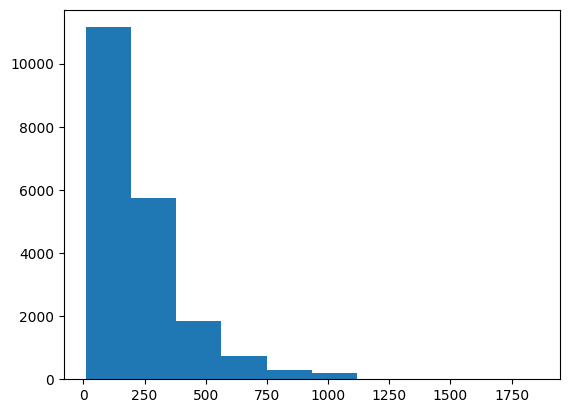

In [ ]:
# train_data의 길이를 리스트에 저장
import matplotlib.pyplot as plt
train_data_len = [len(x) for x in train_data]
plt.hist(train_data_len)
plt.show()

In [ ]:
# 시퀸스 패딩
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=100)
print(train_data.shape, train_seq.shape)

(20000,) (20000, 100)


In [ ]:
print(train_data[0], train_data[0])

[1, 73, 89, 81, 25, 60, 2, 6, 20, 2, 17, 14, 31, 2, 12, 60, 28, 2, 2, 66, 45, 6, 20, 15, 2, 8, 79, 17, 2, 8, 2, 6, 2, 20, 17, 2, 2, 4, 2, 20, 9, 2, 6, 2, 7, 2, 2, 6, 2, 2, 24, 55, 2, 5, 23, 2, 7, 15, 82, 24, 15, 2, 66, 10, 10, 45, 2, 15, 4, 20, 2, 8, 30, 17, 2, 5, 2, 17, 2, 2, 4, 20, 9, 43, 32, 99, 2, 18, 15, 8, 2, 46, 17, 2, 4, 2, 5, 2, 9, 32, 2, 5, 2, 2, 17, 73, 17, 2, 36, 26, 2, 43, 2, 83, 4, 2, 2, 74, 83, 4, 2, 2, 82, 4, 96, 4, 2, 2, 8, 32, 4, 2, 9, 2, 2, 13, 2, 48, 14, 16, 2, 2, 59, 62, 69, 2, 12, 46, 50, 9, 53, 2, 74, 2, 11, 14, 31, 2, 10, 10, 4, 20, 9, 2, 2, 2, 5, 45, 6, 2, 2, 33, 2, 8, 2, 2, 2, 5, 2, 17, 73, 17, 2, 5, 2, 19, 55, 2, 2, 92, 66, 2, 14, 20, 93, 76, 2, 2, 33, 4, 58, 12, 2, 2, 2, 12, 2, 69, 2, 2, 73, 2, 6, 2, 7, 2, 2, 2, 2, 2, 14, 31, 10, 10, 2, 7, 2, 5, 2, 80, 91, 2, 30, 2, 34, 14, 20, 2, 50, 26, 2, 49, 2, 84, 46, 50, 37, 80, 79, 6, 2, 46, 7, 14, 20, 10, 10, 2, 2] [1, 73, 89, 81, 25, 60, 2, 6, 20, 2, 17, 14, 31, 2, 12, 60, 28, 2, 2, 66, 45, 6, 20, 15, 2, 8, 79, 17, 

In [ ]:
# RNN 적용
vocab_size = 500
print(train_seq.shape)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(500,)),
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.SimpleRNN(8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# model.summary()
# 모델 훈련
# 원핫 인코딩
# train_oh = tf.keras.utils.to_categorical(train_seq)
# print(train_oh.shape)
model.compile(optimizer='adam',
              # loss='binary_crossentropy',
              loss = tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
history = model.fit(train_seq, train_labels,
                    epochs=2,
                    batch_size=32,
                    validation_split=0.2)

(20000, 100)
Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5100 - loss: 0.6954 - val_accuracy: 0.5357 - val_loss: 0.6886
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5695 - loss: 0.6807 - val_accuracy: 0.5238 - val_loss: 0.6881


In [ ]:
# 리뷰데이터를 한글
# 문장
import pandas as pd
import re
train_texts = [
    '이 영화는 재미 있었어요 *^-^*',
    '정말 감동적인 영화였어요',
    '시간이 zzz 너무 아깝습니다.',
    '배우들의 연기가 너무 좋았어요 he~~~',
    '스토리가 별로였어요',
]
train_label = [1,1,0,1,0]
train_df = pd.DataFrame({'text':train_texts, 'label':train_label})
# 데이터 전처리 함수
def custom_standardztion(input_data):
  input_data = re.sub(r'<.*?>',"",input_data)
  input_data = re.sub(r'[^ㄱ-ㅎ가-힣\s]',"",input_data)  # 한글과 공백만 남기
  return input_data.strip()

tokenizer = tf.keras.preprocessing.text.Tokenizer()
train_df['text'] = train_df['text'].map(custom_standardztion)
tokenizer.fit_on_texts(train_df['text'])
print(tokenizer.word_index)
train_sequence = tokenizer.texts_to_sequences(train_df['text'])
print(train_sequence)
max_len = 5 # 최대 문장의 길이
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_sequence, maxlen=max_len)
print(train_pad)
vocab_size = len(tokenizer.word_index) + 1
# RNN 모델
# 파이퍼파라메터
embbeding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_len,)),
    tf.keras.layers.Embedding(vocab_size, output_dim = embbeding_dim),
    tf.keras.layers.SimpleRNN(16,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss = tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
model.summary()

{'너무': 1, '이': 2, '영화는': 3, '재미': 4, '있었어요': 5, '정말': 6, '감동적인': 7, '영화였어요': 8, '시간이': 9, '아깝습니다': 10, '배우들의': 11, '연기가': 12, '좋았어요': 13, '스토리가': 14, '별로였어요': 15}
[[2, 3, 4, 5], [6, 7, 8], [9, 1, 10], [11, 12, 1, 13], [14, 15]]
[[ 0  2  3  4  5]
 [ 0  0  6  7  8]
 [ 0  0  9  1 10]
 [ 0 11 12  1 13]
 [ 0  0  0 14 15]]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 5, 16)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_pad, train_df['label'], epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4000 - loss: 0.6992
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.4000 - loss: 0.6957
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6000 - loss: 0.6922
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8000 - loss: 0.6888
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8000 - loss: 0.6856
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.6826
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.6800
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.6775
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.6749
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.6723


In [ ]:
# 추론
# 학습에 사용했던 토크나이져를 사용
new_texts = ['와 이 영화는 재미 있었어요','이 영화는 아깝습니다']
new_sequence = tokenizer.texts_to_sequences(new_texts)
print(new_sequence)
new_pad = tf.keras.preprocessing.sequence.pad_sequences(new_sequence, maxlen=max_len)
print(new_pad)
predics = model.predict(new_pad)
['긍정' if p>0.5 else '부정'  for p in predics]

[[2, 3, 4, 5], [2, 3, 10]]
[[ 0  2  3  4  5]
 [ 0  0  2  3 10]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


['긍정', '부정']

In [6]:
import pandas as pd
movie_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt',sep='\t')
movie_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [7]:
!pip install koeda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.15.0
    Uninstalling tweepy-4.15.0:
      Successfully uninstalled tweepy-4.15.0


In [8]:
from koeda import EDA
train_texts = [
    '이 영화는 재미 있었어요 *^-^*',
    '정말 감동적인 영화였어요',
    '시간이 zzz 너무 아깝습니다.',
    '배우들의 연기가 너무 좋았어요 he~~~',
    '스토리가 별로였어요',
]
# okt 한글 형태소 분석기
eda = EDA(morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.3, alpha_rs=0.3, prob_rd=0.3)

In [9]:
# data argumentation
for text in train_texts:
  print(eda(text))

이 영화는 *^-^*
정말 감동였어요인 영화적
시간엄니 zzz 너무 아깝습니다.
들의 연기 너무 좋았어요 he~~~
스토리가 별로였어요


In [10]:
movie_df.dropna(inplace=True)
movie_df.duplicated

<bound method DataFrame.duplicated of               id                                           document  label
0        8112052                                어릴때보고 지금다시봐도 재밌어요ㅋㅋ      1
1        8132799  디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...      1
2        4655635               폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.      1
3        9251303  와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...      1
4       10067386                        안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.      1
...          ...                                                ...    ...
199995   8963373                                     포켓 몬스터 짜가 ㅡㅡ;;      0
199996   3302770                                              쓰.레.기      0
199997   5458175                  완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.      0
199998   6908648                왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ      0
199999   8548411                                    포풍저그가나가신다영차영차영차      0

[199992 rows x 3 columns]>

In [11]:
def custom_standardztion(input_data):
  input_data = re.sub(r'<.*?>',"",input_data)
  input_data = re.sub(r'[^가-힣\s]',"",input_data)  # 한글과 공백만 남기
  return input_data.strip()

In [13]:
import re
# 한글만 선택 - 전처리
movie_df['document'] = movie_df['document'].map(custom_standardztion)

# 데이터 분할
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(movie_df['document'], movie_df['label'], test_size=.2, random_state=42)

In [14]:
train_texts

,document
199130,몇몇 훌륭한 글귀를 집어넣었다고 좋은 영화가 되는 것이 아니다 약빨고 만든 영화
122470,타잔은 디즈니지 영상만 잘 만들고 스토리는 노답
15044,범죄자 인권에대해서 다시 한번 생각 해보게됨
11425,재미있다
121115,영웅이라길래 으리성님을 기대하고 왔는데 뭐야 이기야우덜 으리성님을 내놓으랑께으리
...,...
119883,카메라의 떨림 거북스럽다 머리를 아프게 한다
103698,보지마라 형이말한다
131937,매력적인 르네 젤위거가 나오지만 스토리는 글쎄
146872,나 이런 사람이야


In [16]:
import tensorflow as tf
# 토크나이져, 시퀀스 처리
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequence = tokenizer.texts_to_sequences(train_texts)
val_sequence = tokenizer.texts_to_sequences(val_texts)

In [17]:
# 문장의 최대 길이
max_len = 100
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequence, maxlen=max_len)
val_padded = tf.keras.preprocessing.sequence.pad_sequences(val_sequence, maxlen=max_len)

In [19]:
# 단어사전 크기
vocab_size = len(tokenizer.word_index) + 1
# 모델 생성
output_dim = 16
print(train_padded.shape)  # 100
kmodel = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_len,)),
    tf.keras.layers.Embedding(vocab_size,output_dim),
        tf.keras.layers.SimpleRNN(16,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
kmodel.compile(optimizer='adam',
              loss = tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
# 모델 학습
history = kmodel.fit(train_padded, train_labels, epochs=5,
                    validation_data=(val_padded, val_labels),batch_size = 32)

(159993, 100)
Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.7214 - loss: 0.5210 - val_accuracy: 0.8097 - val_loss: 0.3902
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.9295 - loss: 0.1931 - val_accuracy: 0.8010 - val_loss: 0.4556
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9685 - loss: 0.0835 - val_accuracy: 0.8019 - val_loss: 0.5277
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9809 - loss: 0.0480 - val_accuracy: 0.7933 - val_loss: 0.6404
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9861 - loss: 0.0332 - val_accuracy: 0.7901 - val_loss: 0.7691


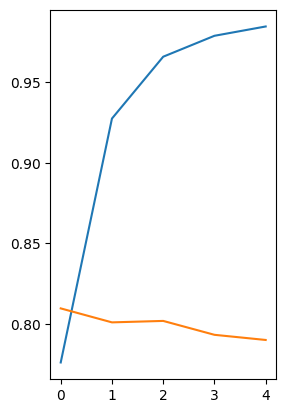

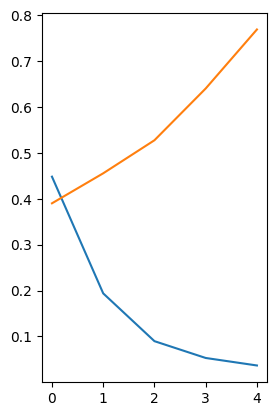

In [20]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [21]:
import numpy as np
new_texts = ['영화보다가 잤어요 ','너무 재미 있습니다.']
new_sequence = tokenizer.texts_to_sequences(new_texts)
new_padded = tf.keras.preprocessing.sequence.pad_sequences(new_sequence, maxlen=max_len)
predics = kmodel.predict(new_padded)
np.round(predics,5), predics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


(array([[0.     ],
        [0.97716]], dtype=float32),
 array([[3.9449683e-06],
        [9.7716421e-01]], dtype=float32))

성능개선
```
데이터 증강
EDA(Easy Data Augumentation)
KoEDA
  동어의치환, 단어삭제, 단어순서변경,랜덤단어삽입
  형태소 Okt  

토근화
  BPE : 연속된 단어쌍을 병합해서 사전을 생성
  WordPiece : BERT라는 언어모델에서 사용, 확률 기반
  SentencePiece : 공백을 무시하고 학습

Word Embedding 기법
Word2Vec  : 단어의 분포를 고려한 벡터
FastText : 서브워드를 학습 희귀단어도 처리가능
BERT Embedding : 문맥을 고려한 동적 벡터
ELECTRA : GAN 방식으로 작은 모델에서도 성능 향상

전처리기법
이모티콘이나 특수문자 제거
정규화 : 'ㅋㅋㅋ' 재미있다 'ㅠ.ㅠ'지루하다 재미 없다
불용어제거 : 의미없는 단어 그래서, 그런데, 하지만
```

```
RAN
  데이터 증강
  최신 토크나이져 적용
  벡터방식
  정제(불용어, 특수문자, 이모티콘 등등)
  정규화 : 필요시.. 줄임말을 표준어 표현
```

기존코드에 Word2Vec 적용
```
word2vec 사전 학습된 임베딩을 사용
  word2vec 모델 학습
  학습된 가중치를 keras embedding 레이어 적용
```

In [1]:
!pip install --upgrade --force-reinstall gensim numpy

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [2]:
import pandas as pd
import string, re
import tensorflow as tf
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split

movie_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt',sep='\t')
movie_df.dropna(inplace=True)
def custom_standardztion(input_data):
  input_data = re.sub(r'<.*?>',"",input_data)
  # 특수문자를 공백으로 변경 string 라이브러리 이용
  input_data = re.sub(r'[^가-힣\s]'," ",input_data)  # 한글과 공백만 남기
  return input_data.strip()
X = movie_df['document'].map(custom_standardztion)
y = movie_df['label']
train_texts, val_texts, train_labels, val_labels \
= train_test_split(X, y, test_size=.2, random_state=42)

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequence = tokenizer.texts_to_sequences(train_texts)
val_sequence = tokenizer.texts_to_sequences(val_texts)

w2v_model = Word2Vec(train_sequence, vector_size=100, window=5, min_count=1, workers=4)

In [3]:
w2v_model.wv.most_similar(1)

[(59, 0.9712027311325073),
 (27, 0.9552158117294312),
 (301, 0.9539399147033691),
 (159, 0.9527314305305481),
 (639, 0.9513718485832214),
 (66, 0.9488875269889832),
 (239, 0.9468587636947632),
 (8957, 0.9418534636497498),
 (1016, 0.940928041934967),
 (2602, 0.9389902949333191)]

# Word2vec 임베딩 벡터 - 유사도 기반 비슷한 단어를 찾아주는 기능
```

RNN
  순환 신경망 : 이전상태(hidden)가 다음상태에 업데이트
  문자의단어는 앞으로 단어에 영향을 받는다
  사계열데이터 X축이 시간과 관련된 수치 데이터

문장을 - 토큰화 - 시퀀스(문장의 길이를 통일,정수형 인코딩) - 임베딩(단어를 좌표평면에 벡터화 유사한 단어는 유사한 공간에 위치) - 신경망(RNN)
 - 분류기(FC)
```